# Compte Rendu du TP SVM
### Auteurs : Boubacar TRAORE & Zakarya JARRAYA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Changement de la police utilisée et de sa taille
from IPython.core.display import HTML, display
from tp_tools import change_font
display(HTML(change_font()))

In [4]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [173]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from nltk.stem import WordNetLemmatizer
from sklearn import svm
import langid
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

Lecture et affichaque de quelques observations de la base de données.

In [98]:
full_corpus = pd.read_csv('twitter_corpus/full-corpus.csv')
full_corpus.sample(5, random_state=0)

,Topic,Sentiment,TweetId,TweetDate,TweetText
42,apple,positive,126164430546403328,Tue Oct 18 05:15:18 +0000 2011,Incredible: 4 million iPhone 4Ss in 3 days. 13...
3354,microsoft,irrelevant,126781181466378240,Wed Oct 19 22:06:03 +0000 2011,#Microsoft: Una pantalla táctil al alcance de ...
311,apple,negative,125982320917364736,Mon Oct 17 17:11:40 +0000 2011,For being the inventor of the computer mouse —...
906,apple,neutral,125498684401135616,Sun Oct 16 09:09:52 +0000 2011,The battle of voice controlled AI platforms. I...
1979,google,neutral,126484018211454976,Wed Oct 19 02:25:14 +0000 2011,#Android #Google Samsung and Google introduce ...


## Traitement de la base

In [99]:
full_corpus.shape

(5113, 5)

On a 5113 tweets. Il y a plusieurs langues que nous pouvons directement voir dans la colonne TweetText, par exemple la 2e observation est de l'espagnol. Il est necessaire de faire un traitement particulier selon le langage utilisé pour le tweet.

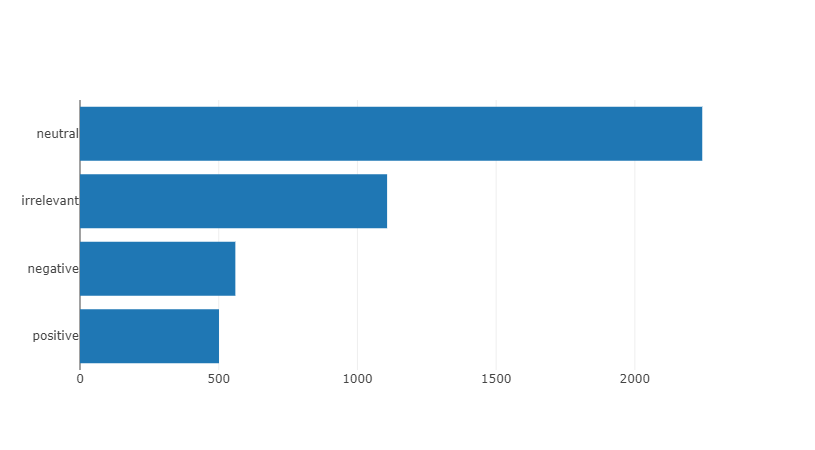

In [179]:
s = full_corpus.Sentiment.value_counts(ascending=True)
data  = [go.Bar(
            x= s.values,
            y=s.index,
            orientation = 'h'
)]
iplot(data)

Les commentaires neutres sont les plus nombreux. Nous avons un déséquilibre au niveau de la classe à prédire. Nous tenons compte de ce cas pour certains modèles.

## Détection de langage

In [101]:
full_corpus['language'] = full_corpus.TweetText.apply(lambda r: langid.classify(r)[0])
full_corpus.sample(5, random_state=24)

,Topic,Sentiment,TweetId,TweetDate,TweetText,language
346,apple,negative,125845538926112768,Mon Oct 17 08:08:09 +0000 2011,"@apple, your update server has been timing out...",en
3867,twitter,positive,126863821594832897,Thu Oct 20 03:34:26 +0000 2011,Dear #twitter I have missed you. Promise i'll ...,en
3309,microsoft,neutral,126483887923793920,Wed Oct 19 02:24:43 +0000 2011,#microsoft makes every surface a touch screen ...,en
1832,google,neutral,126496131382382592,Wed Oct 19 03:13:22 +0000 2011,Calling All #IceCreamSandwich Lovers | #Google...,en
943,apple,neutral,125360952878182400,Sun Oct 16 00:02:35 +0000 2011,Too many iPhones. @apple @dcoult #FirstWorldP...,en


In [102]:
full_corpus.language.value_counts(normalize=True).head(4)

en    0.670252
es    0.124976
fr    0.036182
de    0.031293
Name: language, dtype: float64

In [103]:
full_corpus.language.value_counts(normalize=True).head(4).sum()

0.8627029141404264

Nous remarquons que 86,2% des tweets sont en anglais, espagnol, francais et allemand (German). Nous n'allons nous intéresser qu'à ces quatres langages pour l'instant. 

In [127]:
# On ne s'interese qu'aux tweets faits dans les quatres langues populaires
# Le nombre total de tweets chute à 4 411.
full_corpus[full_corpus.language.isin(lang_list)].shape

(4411, 6)

## Nettoyage des stop_words selon le langage utilisé

In [104]:
lang_list = full_corpus.language.value_counts(normalize=True).head(4).index.values.tolist()
lang_list

['en', 'es', 'fr', 'de']

In [157]:
#selection  des langues
full_corpus = full_corpus[full_corpus.language.isin(lang_list)].reset_index()

In [129]:
lang_dict = dict(zip(lang_list, ['english', 'spanish', 'french','german']))
lang_dict

{'en': 'english', 'es': 'spanish', 'fr': 'french', 'de': 'german'}

In [130]:
full_corpus.Sentiment.value_counts(normalize=True)

neutral       0.508501
irrelevant    0.250964
negative      0.126955
positive      0.113580
Name: Sentiment, dtype: float64

On définit un lemmatizer qui permet de regrouper des types de mots identiques (par exemple "dogs" et "dog" sont les mêmes en anglais et il serait inutile de les compter doublement). Elle utilisée dans la fonction "clean_tweet". Cette dernière contient aussi les instructions pour mettre en minuscule chaque mot rencontré.

In [140]:
lemmatizer = WordNetLemmatizer()

In [141]:
# function to drop stopwords from each observation (selon la langue)
# il faut tout mettre en minuscule aussi et utiliser le lemmatizer pour remettre les mots similaires ensemble
lemmatizer = WordNetLemmatizer()
def clean_tweet(r):
    words = r.TweetText.split(' ')
    words = [lemmatizer.lemmatizer(word.lower()) for word in words if word not in list(set(stopwords.words(lang_dict[r.language])))]
    return ' '.join(words)

In [142]:
full_corpus['CleanTweetText'] = full_corpus.apply(clean_tweet, axis=1)
full_corpus.sample(5, random_state=0)

,Topic,Sentiment,TweetId,TweetDate,TweetText,language,CleanTweetText
1154,google,positive,126530945976238080,Wed Oct 19 05:31:43 +0000 2011,I fancy an Ice Cream Sandwich #google #android...,en,i fancy ice cream sandwich #google #android. w...
1331,google,positive,126487508589621248,Wed Oct 19 02:39:06 +0000 2011,Thank god Gmail app has been redesigned under ...,en,thank god gmail app redesigned android 4.0. co...
121,apple,positive,125628199269961729,Sun Oct 16 17:44:31 +0000 2011,@Apple's Siri is witchcraft. What's next @goo...,en,@apple's siri witchcraft. what's next @google...
4595,twitter,irrelevant,126880477943570433,Thu Oct 20 04:40:37 +0000 2011,#Facebook ah quedado en el olvido gracias a #T...,es,#facebook ah quedado olvido gracias #twitter
2617,microsoft,negative,126675041353076738,Wed Oct 19 15:04:18 +0000 2011,#microsoft update is so slow :(( http://t.co/...,en,#microsoft update slow :(( http://t.co/37ighgic


In [148]:
full_corpus.CleanTweetText

0               now @apple get swype iphone crack. iphone
1       @apple adding carrier support iphone 4s (just ...
2       hilarious @youtube video - guy duet @apple 's ...
3            @rim made easy switch @apple iphone. see ya!
4       i realized reason i got twitter ios5 thanks @a...
5       i'm current @blackberry user, little bit disap...
6       the 16 strangest things siri said far. i sooo ...
7       great close & personal event @apple tonight re...
8       from companies experience best customer servic...
9                    just apply job @apple, hope call lol
10      rt @jamaicanidler: lmao i think @apple onto so...
11      lmao i think @apple onto something magical! i ...
12      rt @philliprowntree: just registered @apple de...
14      just registered @apple developer... here's hop...
15      你好 ! currently learning mandarin upcoming trip...
16      come dark side 📱“@gretcheneclark: hey @apple, ...
17      hey @apple, send free iphone (any version do),...
18      thank 

Les commentaires semblent bien nettoyés ont été netoyées.

## Countvectorizer avec unigramme

### Modèle bayésien naif gaussien

In [184]:
# create parser of words
parser = CountVectorizer()

In [185]:
kf = KFold(n_splits=5, random_state=42) 
gnb = GaussianNB()

In [186]:
X_full = parser.fit_transform(full_corpus.CleanTweetText).toarray()
X_full

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [187]:
for train_index, test_index in kf.split(full_corpus):
    # Transform regressors to sparse Matrix
    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train, y_test = full_corpus.Sentiment[train_index], full_corpus.Sentiment[test_index]
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    print("-------------------------------")
    accuracy = (y_pred == y_test).mean()
    print('accuracy = ', accuracy)

-------------------------------
accuracy =  0.4360135900339751
-------------------------------
accuracy =  0.5
-------------------------------
accuracy =  0.4365079365079365
-------------------------------
accuracy =  0.5476190476190477
-------------------------------
accuracy =  0.54421768707483


## Utilisation des bigrams

In [188]:
# create parser of words
parser = CountVectorizer(ngram_range=(1,2))
X_full = parser.fit_transform(full_corpus.CleanTweetText).toarray()

In [189]:
for train_index, test_index in kf.split(full_corpus):
    # Transform regressors to sparse Matrix
    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train, y_test = full_corpus.Sentiment[train_index], full_corpus.Sentiment[test_index]
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    print("-------------------------------")
    accuracy = (y_pred == y_test).mean()
    print('accuracy = ', accuracy)

-------------------------------
accuracy =  0.4552661381653454
-------------------------------
accuracy =  0.5102040816326531
-------------------------------
accuracy =  0.42290249433106575
-------------------------------
accuracy =  0.5680272108843537
-------------------------------
accuracy =  0.6190476190476191


Nous constatons que le modèle s'améliore légèrement pour chaque fold de notre validation croisée. Comme on s'y attendait, les bigrammes collent mieux à la détectionde langage humain via les tweets.

## Et mainenant du svm

In [190]:
clf = svm.SVC(gamma='scale', class_weight='balanced', C=1)

In [ ]:
for train_index, test_index in kf.split(full_corpus):
    # Transform regressors to sparse Matrix
    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train, y_test = full_corpus.Sentiment[train_index], full_corpus.Sentiment[test_index]
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    print("-------------------------------")
    accuracy = (y_pred == y_test).mean()
    print('accuracy = ', accuracy)

-------------------------------
accuracy =  0.15288788221970556


Les résultats sont moins bons dans le cas d'un SVM !! A noter qu'il est également possible de tuner les paramètres pour obtenir de meilleures performances. Comme indicateur de mesure, la précision n'est pas forcément un excellent indicateur, nous pouvons observer d'autres indicateurs de performances tels que le la matrice de confusion, le F1-score, etc..